In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

import pickle
from tqdm import tqdm
import copy

In [2]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoLaplaceApproximation

c:\Users\Revalda Putawara\.conda\envs\bnntest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd

In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [5]:
from utils.model import LaplaceBayesianCNNSingleFC

In [6]:
from bitflip import bitflip_float32

In [7]:
def load_data(batch_size=54):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=False)

    torch.manual_seed(42)
    
    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    # Add num_workers and pin_memory for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [8]:
train_loader, test_loader = load_data(batch_size=54)

In [9]:
device = torch.device("cuda")

In [10]:
num_classes = 10

In [11]:
bayesian_model =LaplaceBayesianCNNSingleFC(num_classes=num_classes, device=device).to(device)

In [12]:
#model_path = 'results_eurosat/bayesian_cnn_model_std10_100_epoch_laplace.pth'
#guide_path = 'results_eurosat/bayesian_cnn_guide_std10_100_epoch_guide_laplace.pth'
pyro_param_store_path = 'results_eurosat/pyro_param_store_std10_100_epoch_laplace_MAP.pkl'

#guide = AutoDiagonalNormal(bayesian_model).to(device)

#pyro.get_param_store().set_state(torch.load(pyro_param_store_path,weights_only=False))

#original_param_store = {}

#for name, value in pyro.get_param_store().items():
#    print(f"{name}: {value.shape}")
#    original_param_store[name] = torch.tensor(value.data, requires_grad=value.requires_grad)

In [13]:
class LaplaceInjector:
    def __init__(self, trained_model, device, test_loader, num_samples):
        """
        Initializes SEU injector
        """

        #initialize device
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        self.trained_model = trained_model.to(self.device)
        self.test_loader = test_loader
        self.trained_model.eval()
        self.num_samples = num_samples
        
        self.guide = AutoLaplaceApproximation(self.trained_model).to(self.device)
        pyro.get_param_store().clear()
        pyro.get_param_store().set_state(torch.load(pyro_param_store_path,weights_only=False))

        #initial_Accuracy = self.return_accuracy(num_samples)
        initial_labels, initial_predictions, initial_logits, initial_probs = self.predict_data_probs(self.num_samples)
        self.initial_accuracy = self.return_accuracy(initial_labels, initial_predictions)
        
        #print accuracy before SEU
        print(f"Initial accuracy: {self.initial_accuracy}")
        
    def predict_data_probs(self, num_samples=10):
        all_labels = []
        all_predictions = []
        all_logits = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="Evaluating"):
                images, labels = images.to(self.device), labels.to(self.device)

                logits_mc = torch.zeros(num_samples, images.size(0), self.trained_model.fc1.out_features).to(device)

                for i in range(num_samples):
                    guide_trace = pyro.poutine.trace(self.guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(self.trained_model, trace=guide_trace)
                    logits = replayed_model(images)
                    logits_mc[i] = logits

                avg_logits = logits_mc.mean(dim=0)
                predictions = torch.argmax(avg_logits, dim=1)

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
                all_logits.extend(avg_logits.cpu().numpy())
                all_probs.extend(F.softmax(avg_logits, dim=1).cpu().numpy())

        return all_labels, all_predictions, all_logits, all_probs

    def return_accuracy(self, all_labels, all_predictions):
        #all_labels, all_predictions, all_logits, all_probs = self.predict_data_probs(num_samples)
        cm = confusion_matrix(all_labels, all_predictions)
        accuracy = np.trace(cm) / np.sum(cm)

        return accuracy
    
    def run_seu_autolaplace_approximation(self, location_index, bit_i, parameter_name="loc", num_samples=10):
        """
        Run SEU on the AutoDiagonalNormal guide
        """

        assert parameter_name in ["loc"], "Parameter name must be 'loc' or 'scale'."
        assert bit_i in range(0, 33), "Location index must be between 0 and 9."

        if parameter_name == "loc":
            param_store_name = "AutoLaplaceApproximation.loc"

        pyro.get_param_store().set_state(torch.load(pyro_param_store_path,weights_only=False))

        with torch.no_grad():
            param_dict = {}

            for name, value in pyro.get_param_store().items():
                #print(f"{name}: {value.shape}")
                #print(value)
                param_dict[name] = value.cpu().detach().numpy()

            tensor_cpu = param_dict[param_store_name]

            #original_val = tensor_cpu[0] #this zero index should be changed to the location_index
            original_val = tensor_cpu[location_index]
            seu_val = bitflip_float32(original_val, bit_i)


            print(f"Original value: {original_val}, SEU value: {seu_val}")

            # Get the parameter
            param = pyro.get_param_store().get_param(param_store_name)

            # Modify it safely by creating a new tensor
            new_param = param.clone()
            new_param[location_index] = seu_val  # New Value

            # Update the parameter store
            if parameter_name == "loc":
                pyro.get_param_store().__setitem__(param_store_name, new_param) # 74%
                #param_store[param_store_name].data.copy_(change_item(param_store_name, location_index, seu_val)) #25%
                #pyro.get_param_store()[param_store_name].data[location_index] = seu_val # 25%
            elif parameter_name == "scale":
                pyro.get_param_store().__setitem__(param_store_name, new_param) #10%
                #pyro.get_param_store()[param_store_name].data[location_index] = seu_val

        #print accuracy after SEU
        self.guide = AutoLaplaceApproximation(bayesian_model).to(device)
    

        try:
            after_labels, after_predictions, after_logits, after_probs = self.predict_data_probs(num_samples)
            accuracyAfter_SEU = self.return_accuracy(after_labels, after_predictions)
        except:
            accuracyAfter_SEU = np.nan
            
        print(f"Accuracy after SEU: {accuracyAfter_SEU}")
        print("===================================")

        return accuracyAfter_SEU - self.initial_accuracy

In [14]:
inj = LaplaceInjector(trained_model=bayesian_model, device=device, test_loader=test_loader, num_samples=10)

Evaluating: 100%|██████████| 100/100 [00:33<00:00,  3.03it/s]

Initial accuracy: 0.9362962962962963


In [ ]:
#inj.run_seu_autodiagonal_normal(location_index=0, bit_i=1, parameter_name="scale", num_samples=10)
#inj.run_seu_autolaplace_approximation(location_index=0, bit_i=2, parameter_name="loc", num_samples=10)

In [ ]:
# print pyro parameters
for name, value in pyro.get_param_store().items():
     print(f"{name}: {value.shape}")

In [ ]:
inj.guide.get_posterior()

In [ ]:
#store the result in dataframe
import pandas as pd
results = []

for i in range(0, 32):
    results.append(inj.run_seu_autolaplace_approximation(location_index=0, bit_i=i, parameter_name="loc", num_samples=10))

In [ ]:
# plot the result in matplotlib
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results, marker='o')
plt.title('SEU Impact on Scale Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

In [15]:
results_loc = []

for i in range(0, 32):
    results_loc.append(inj.run_seu_autolaplace_approximation(location_index=0, bit_i=i, parameter_name="loc", num_samples=10))

Original value: 2.0336058139801025, SEU value: -2.0336058139801025


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 12.49it/s]


Accuracy after SEU: 0.8883333333333333
Original value: 2.0336058139801025, SEU value: 1.9751722244197594e-40


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 12.89it/s]


Accuracy after SEU: 0.9237037037037037
Original value: 2.0336058139801025, SEU value: 3.7513405997298745e+19


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


Accuracy after SEU: 0.2783333333333333
Original value: 2.0336058139801025, SEU value: 8734270464.0


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


Accuracy after SEU: 0.2783333333333333
Original value: 2.0336058139801025, SEU value: 133274.390625


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


Accuracy after SEU: 0.2783333333333333
Original value: 2.0336058139801025, SEU value: 520.6030883789062


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 12.88it/s]


Accuracy after SEU: 0.32296296296296295
Original value: 2.0336058139801025, SEU value: 32.53769302368164


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


Accuracy after SEU: 0.67
Original value: 2.0336058139801025, SEU value: 8.13442325592041


Evaluating: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


Accuracy after SEU: 0.877962962962963
Original value: 2.0336058139801025, SEU value: 4.067211627960205


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


Accuracy after SEU: 0.9251851851851852
Original value: 2.0336058139801025, SEU value: 3.0336058139801025


Evaluating: 100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


Accuracy after SEU: 0.9337037037037037
Original value: 2.0336058139801025, SEU value: 2.5336058139801025


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


Accuracy after SEU: 0.9355555555555556
Original value: 2.0336058139801025, SEU value: 2.2836058139801025


Evaluating: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.1586058139801025


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


Accuracy after SEU: 0.9361111111111111
Original value: 2.0336058139801025, SEU value: 2.0961058139801025


Evaluating: 100%|██████████| 100/100 [00:12<00:00,  7.89it/s]


Accuracy after SEU: 0.9366666666666666
Original value: 2.0336058139801025, SEU value: 2.0023558139801025


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


Accuracy after SEU: 0.9357407407407408
Original value: 2.0336058139801025, SEU value: 2.0492308139801025


Evaluating: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.0414183139801025


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.0375120639801025


Evaluating: 100%|██████████| 100/100 [00:13<00:00,  7.67it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.0316526889801025


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.0345823764801025


Evaluating: 100%|██████████| 100/100 [00:13<00:00,  7.60it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.0340940952301025


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.0333616733551025


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.0334837436676025


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.0336668491363525


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.0335752964019775


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.033621072769165


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.033613443374634


Evaluating: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.033601999282837


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.0336039066314697


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.033606767654419


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.0336062908172607


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 2.0336058139801025, SEU value: 2.0336055755615234


Evaluating: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]

Accuracy after SEU: 0.9362962962962963


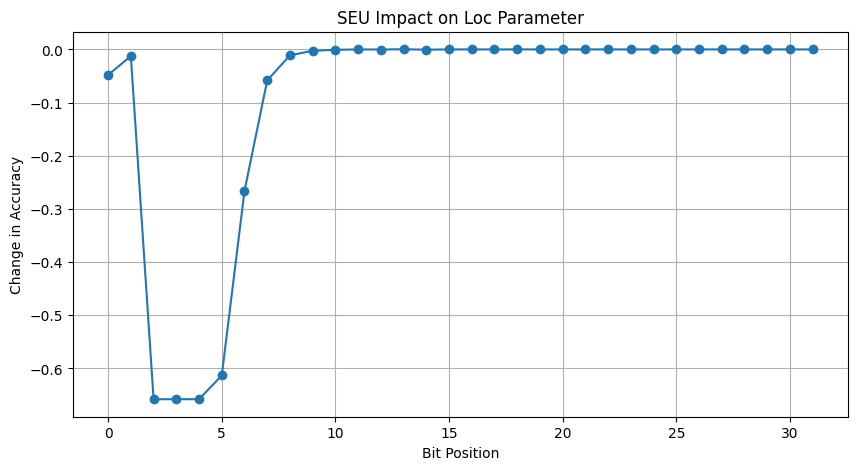

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results_loc, marker='o')
plt.title('SEU Impact on Loc Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

In [ ]:
#(inj.run_seu_autodiagonal_normal(location_index=0, bit_i=0, parameter_name="loc", num_samples=10))

In [18]:
results2_loc = []

for i in range(0, 32):
    results2_loc.append(inj.run_seu_autolaplace_approximation(location_index=217536, bit_i=i, parameter_name="loc", num_samples=10))

Original value: 0.0001677002728683874, SEU value: -0.0001677002728683874


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 12.48it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 5.70654457849421e+34


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 12.84it/s]


Accuracy after SEU: 0.1111111111111111
Original value: 0.0001677002728683874, SEU value: 9.091050008515876e-24


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 3.904576247287621e-14


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.19it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 2.558903089422415e-09


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.042931269854307175


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 12.95it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.0026832043658941984


Evaluating: 100%|██████████| 100/100 [00:11<00:00,  8.59it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 4.192506821709685e-05


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.0003354005457367748


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.0002287354291183874


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.0001371826947433874


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 12.91it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.0001829590619308874


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.0001600708783371374


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.0001638855756027624


Evaluating: 100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.0001657929242355749


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.19it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.00016674659855198115


Evaluating: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.00016722343571018428


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.00016746185428928584


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.00016781948215793818


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.000167640668223612


Evaluating: 100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.0001676704705459997


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.00016771517402958125


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.00016770772344898432


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.00016770399815868586


Evaluating: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.00016769841022323817


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.00016770120419096202


Evaluating: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.0001676998072071001


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.00016770004003774375


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.00016770038928370923


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.00016770033107604831


Evaluating: 100%|██████████| 100/100 [00:12<00:00,  7.75it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.00016770024376455694


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 0.0001677002728683874, SEU value: 0.00016770025831647217


Evaluating: 100%|██████████| 100/100 [00:13<00:00,  7.57it/s]

Accuracy after SEU: 0.9362962962962963


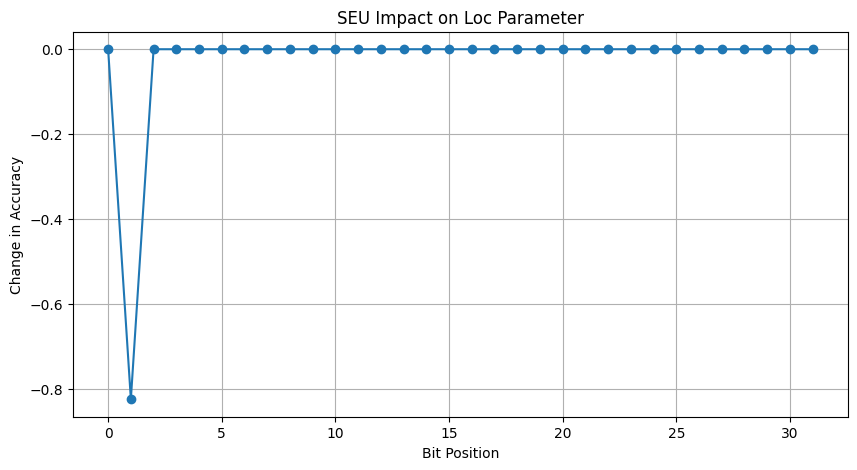

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results2_loc, marker='o')
plt.title('SEU Impact on Loc Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

In [ ]:
bayesian_model

In [ ]:
# print the parameters of the bayesian model
for name, value in bayesian_model.named_parameters():
    print(f"{name}: {value.shape}")

In [ ]:
# print the parameters of pyro param store
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value.shape}")

In [20]:
results3_loc = []

for i in range(0, 32):
    results3_loc.append(inj.run_seu_autolaplace_approximation(location_index=53696, bit_i=i, parameter_name="loc", num_samples=10))

Original value: 4.140442848205566, SEU value: -4.140442848205566


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 1.2167667944920463e-38


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 7.637768957266913e+19


Evaluating: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Accuracy after SEU: 0.8553703703703703
Original value: 4.140442848205566, SEU value: 17783066624.0


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.92it/s]


Accuracy after SEU: 0.8553703703703703
Original value: 4.140442848205566, SEU value: 271348.0625


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


Accuracy after SEU: 0.8553703703703703
Original value: 4.140442848205566, SEU value: 1059.953369140625


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Accuracy after SEU: 0.8975925925925926
Original value: 4.140442848205566, SEU value: 66.24708557128906


Evaluating: 100%|██████████| 100/100 [00:10<00:00,  9.68it/s]


Accuracy after SEU: 0.9346296296296296
Original value: 4.140442848205566, SEU value: 16.561771392822266


Evaluating: 100%|██████████| 100/100 [00:12<00:00,  7.92it/s]


Accuracy after SEU: 0.9361111111111111
Original value: 4.140442848205566, SEU value: 2.070221424102783


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 6.140442848205566


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 5.140442848205566


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 12.64it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.640442848205566


Evaluating: 100%|██████████| 100/100 [00:11<00:00,  8.70it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.390442848205566


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.015442848205566


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.202942848205566


Evaluating: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.171692848205566


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.156067848205566


Evaluating: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.132630348205566


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.136536598205566


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.138489723205566


Evaluating: 100%|██████████| 100/100 [00:12<00:00,  7.95it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.139466285705566


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.83it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.139954566955566


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.140198707580566


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.140564918518066


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.140381813049316


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.140473365783691


Evaluating: 100%|██████████| 100/100 [00:11<00:00,  8.72it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.140458106994629


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.140450477600098


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.140446662902832


Evaluating: 100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.140444755554199


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 12.89it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.14044189453125


Evaluating: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


Accuracy after SEU: 0.9362962962962963
Original value: 4.140442848205566, SEU value: 4.140443325042725


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]

Accuracy after SEU: 0.9362962962962963


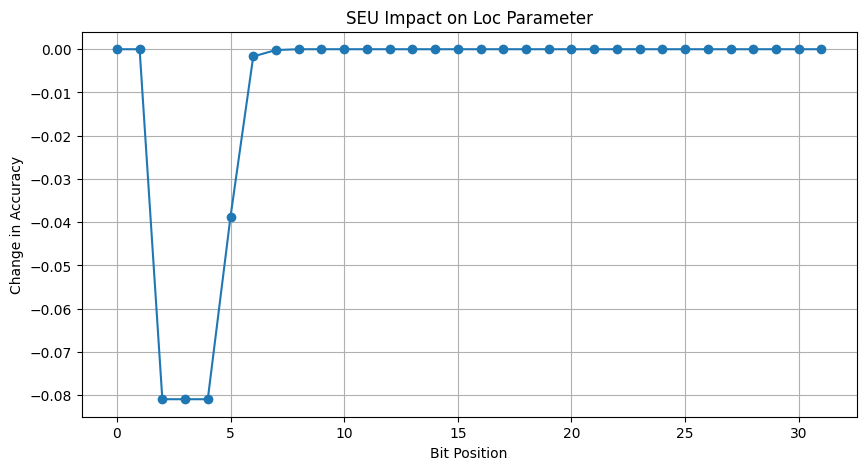

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results3_loc, marker='o')
plt.title('SEU Impact on Loc Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

In [ ]:
import numpy as np

def get_flat_param_index(layer_name, param_type, index_tuple):
    # Define parameter shapes for each layer
    param_shapes = {
        'conv1': {
            'weight': (32, 3, 5, 5),
            'bias': (32,)
        },
        'conv2': {
            'weight': (64, 32, 5, 5),
            'bias': (64,)
        },
        'fc1': {
            'weight': (10, 16384),
            'bias': (10,)
        }
    }

    # Check valid inputs
    if layer_name not in param_shapes:
        raise ValueError(f"Unknown layer '{layer_name}'")
    if param_type not in param_shapes[layer_name]:
        raise ValueError(f"'{param_type}' not found in layer '{layer_name}'")

    # Compute flat offset for each param in order: conv1.weight, conv1.bias, ...
    flat_offset = 0
    for l in ['conv1', 'conv2', 'fc1']:
        for p in ['weight', 'bias']:
            shape = param_shapes[l][p]
            numel = np.prod(shape)

            if l == layer_name and p == param_type:
                # Compute local flat index within this param
                local_flat_index = np.ravel_multi_index(index_tuple, shape)
                return flat_offset + local_flat_index

            flat_offset += numel

    raise RuntimeError("Should not reach here if input is valid.")


In [ ]:
# Index of conv1.bias[5]
print(get_flat_param_index("conv1", "bias", (0,)))  # Output: 2405

# Index of conv2.weight[0,0,0,0]
print(get_flat_param_index("conv2", "weight", (0,0,0,0)))  # Output: 2432

# Index of fc1.weight[0, 0]
print(get_flat_param_index("fc1", "weight", (0, 0)))  # Output: 53696

In [22]:
results4_loc = []

for i in range(0, 32):
    results4_loc.append(inj.run_seu_autolaplace_approximation(location_index=2400, bit_i=i, parameter_name="loc", num_samples=10))

Original value: -0.3891051709651947, SEU value: 0.3891051709651947


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Accuracy after SEU: 0.9337037037037037
Original value: -0.3891051709651947, SEU value: -1.3240562855721288e+38


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 12.12it/s]


Accuracy after SEU: 0.7827777777777778
Original value: -0.3891051709651947, SEU value: -2.1093433584290386e-20


Evaluating: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Accuracy after SEU: 0.9351851851851852
Original value: -0.3891051709651947, SEU value: -9.059560740487527e-11


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Accuracy after SEU: 0.9351851851851852
Original value: -0.3891051709651947, SEU value: -5.9372737268859055e-06


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Accuracy after SEU: 0.9351851851851852
Original value: -0.3891051709651947, SEU value: -0.0015199420740827918


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.51it/s]


Accuracy after SEU: 0.9351851851851852
Original value: -0.3891051709651947, SEU value: -0.02431907318532467


Evaluating: 100%|██████████| 100/100 [00:10<00:00,  9.85it/s]


Accuracy after SEU: 0.9355555555555556
Original value: -0.3891051709651947, SEU value: -1.5564206838607788


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


Accuracy after SEU: 0.929074074074074
Original value: -0.3891051709651947, SEU value: -0.19455258548259735


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


Accuracy after SEU: 0.9364814814814815
Original value: -0.3891051709651947, SEU value: -0.2641051709651947


Evaluating: 100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.4516051709651947


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


Accuracy after SEU: 0.9361111111111111
Original value: -0.3891051709651947, SEU value: -0.4203551709651947


Evaluating: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Accuracy after SEU: 0.9361111111111111
Original value: -0.3891051709651947, SEU value: -0.4047301709651947


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Accuracy after SEU: 0.9359259259259259
Original value: -0.3891051709651947, SEU value: -0.3812926709651947


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.3851989209651947


Evaluating: 100%|██████████| 100/100 [00:11<00:00,  8.63it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.3871520459651947


Evaluating: 100%|██████████| 100/100 [00:10<00:00,  9.33it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.3900817334651947


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.3895934522151947


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.3888610303401947


Evaluating: 100%|██████████| 100/100 [00:11<00:00,  8.67it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.3889831006526947


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.3890441358089447


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.3891356885433197


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.3891204297542572


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.38911280035972595


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.25it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.3891013562679291


Evaluating: 100%|██████████| 100/100 [00:13<00:00,  7.49it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.3891032636165619


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.3891061246395111


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.3891056478023529


Evaluating: 100%|██████████| 100/100 [00:12<00:00,  7.92it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.3891049325466156


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.38910529017448425


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.3891051113605499


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Accuracy after SEU: 0.9362962962962963
Original value: -0.3891051709651947, SEU value: -0.3891051411628723


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]

Accuracy after SEU: 0.9362962962962963


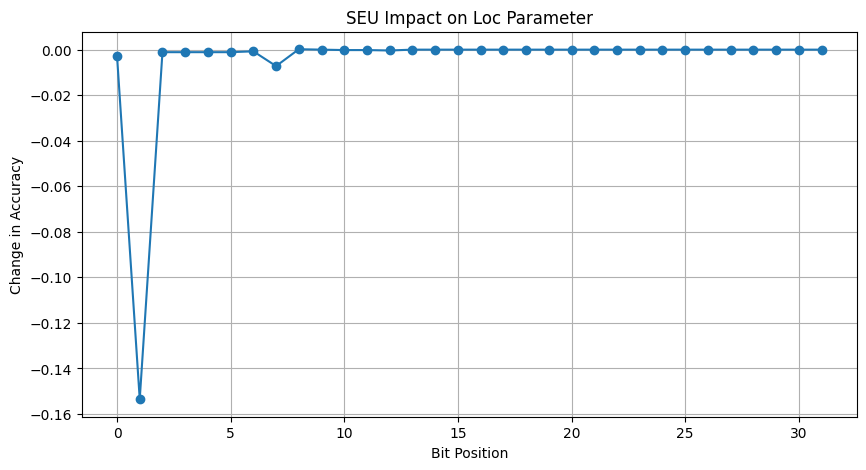

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results4_loc, marker='o')
plt.title('SEU Impact on Loc Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

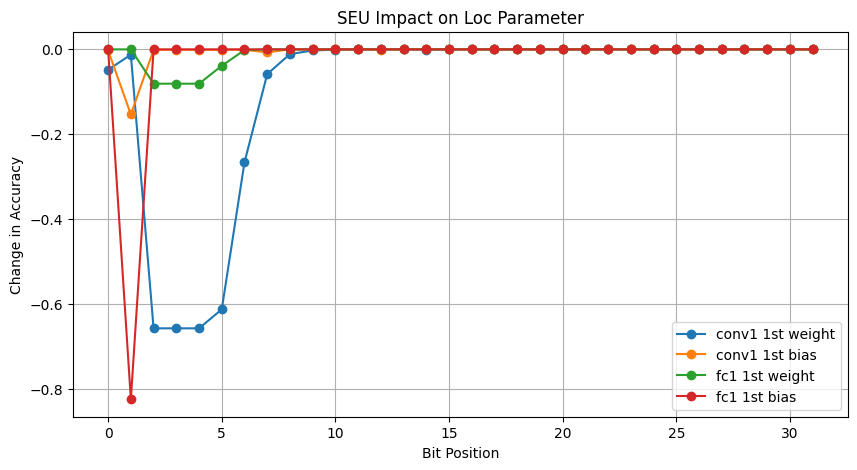

In [24]:
# plot results2_loc, results3_loc, results4_loc in a single plot
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results_loc, marker='o', label='conv1 1st weight')
plt.plot(range(0, 32), results4_loc, marker='o', label='conv1 1st bias')
plt.plot(range(0, 32), results3_loc, marker='o', label='fc1 1st weight')
plt.plot(range(0, 32), results2_loc, marker='o', label='fc1 1st bias')


plt.title('SEU Impact on Loc Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.legend()
plt.show()

In [ ]:
#results
#results2_scale
#...
#...

In [ ]:
results_scale = []

for i in range(0, 32):
    results_scale.append(inj.run_seu_autodiagonal_normal(location_index=0, bit_i=i, parameter_name="scale", num_samples=10))

In [ ]:
#store the result in dataframe
import pandas as pd
results2_scale = []

for i in range(0, 32):
    results2_scale.append(inj.run_seu_autodiagonal_normal(location_index=217536, bit_i=i, parameter_name="scale", num_samples=10))

In [ ]:
#store the result in dataframe
import pandas as pd
results3_scale = []

for i in range(0, 32):
    results3_scale.append(inj.run_seu_autodiagonal_normal(location_index=53696, bit_i=i, parameter_name="scale", num_samples=10))

In [ ]:
#store the result in dataframe
import pandas as pd
results4_scale = []

for i in range(0, 32):
    results4_scale.append(inj.run_seu_autodiagonal_normal(location_index=2400, bit_i=i, parameter_name="scale", num_samples=10))

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results_scale, marker='o', label='conv1 1st weight')
plt.plot(range(0, 32), results4_scale, marker='o', label='conv1 1st bias')
plt.plot(range(0, 32), results3_scale, marker='o', label='fc1 1st weight')
plt.plot(range(0, 32), results2_scale, marker='o', label='fc1 1st bias')


plt.title('SEU Impact on Scale Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.legend()
plt.show()